# Defining prescription type
As an initial starting point to understanding the prescription strings, it is useful to have some idea of the type of the prescription. For exampple is it a drug, catheter, peak flow meter, inhaler  etc... This is useful on a couple of ways.

1. We can pull out prescription strings/codes for general areas
2. We can use a divide and concour strategy. Sobsetting specific types and designing parsers for them. 

Suprisingly the DM+D does not really have a classification of the broad prescription type. It is possible to identify drugs to some degree in the DM+D as they will have an active ingredient, so prescriptions that have active ingredients are by definition drugs, although I am not sure if this covers everything. However, using this approach can only be applied to those prescriptions that occur in the DM+D and not for those we do not know anything about.

It is also possible that SnomedCT might have some useful information for type classification, although the same caveat applies and from looking at the overlap data, it does not look like SnomedCT will rescue many of the strings that can't be found in the DM+D because for a large proportion they are defined within commercial namespaces.

However, it might be possible to use the DM+D and/or SnomedCT data to train classifiers to classify the unknown prescriptions. This document is an exploration of that approach. We will start simple and train a two label classifier for drug/device classification. Note, this is not a binary classifier, rather each prescription can take upto two labels. So, it is possible for something to be a drug and device, for example, inhalers fro Asthma.

Even this simple classification will be useful as then we can concentrate oon the drugs first before moving on through the devices. If I can get this working, I will look at a larger multi-label classifier and include things like catheters etc. 

In [1]:
from prescription_db import orm, stats
from snomed_ct import common, orm as sorm
from upsetplot import from_indicators, plot
from sqlalchemy import func, desc, and_
from tqdm import tqdm
from snomed_ct import query
import pandas as pd
import numpy as np
import sqlalchemy
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Display all pandas columns
from IPython.display import display
pd.options.display.max_columns = None

# Make figures bigger
width = 7
height = 7
dpi = 300

plt.rcParams['figure.figsize'] = [width, height]
plt.rcParams['figure.dpi'] = 200 

Connect to the database and create a session. This version has the DM+D upto the second week of May 2023.

In [3]:
engine = sqlalchemy.create_engine('sqlite:////data/prescription_db/dbs/pres-db-dmd_2023_5_2.db')
sm = sqlalchemy.orm.sessionmaker(bind=engine)
session = sm()

I will also create a connection to the SnomedCT database. I use this for some validation work below.

In [4]:
sno_engine = sqlalchemy.create_engine('sqlite:////data/snomedct/v36.2/snomed-ct-36.2-munge.db')
sno_sm = sqlalchemy.orm.sessionmaker(bind=sno_engine)
sno_session = sno_sm()

## Assessing DM+D prescription overlap with SnomedCT
Initially, we will assess how many of the prescriptions that are in the DM+D, also have SnomedCT relationships that have been imported into the prescription database. For those that don't, we will look to see if it is because they do not exist in SnomedCT or that they just do not exist in the relationships. This is because, only active relationships are explored during the import.

### Looking at the distribution of relationship distances
SnomedCT reletionship data is imported as a flattened attribute list with the minmmal distance of the relationship away from the prescription string being stored. Relationships upto 20 nodes away are being stored but I don't think many (if any have that sort of distance on the snomed tree. So the first job is to get a distribution of the relationship distances. To get an idea.

In [5]:
dist_counts = pd.DataFrame(session.query(
    orm.PresStringSnomed.rel_distance,
    func.count(orm.PresStringSnomed.rel_distance),
).group_by(
    orm.PresStringSnomed.rel_distance
), columns=['rel_distance', 'rel_distance_count'])

In [6]:
dist_counts

rel_distance  rel_distance_count
0              0             2986439
1              1             5016955
2              2             6284965
3              3             6077070
4              4             5048477
5              5             4086534
6              6             3046810
7              7             2336631
8              8             1708623
9              9             1193727
10            10              812159
11            11              541717
12            12              359243
13            13              231298
14            14              140760
15            15               81149
16            16               45257
17            17               24019
18            18               10974
19            19                4680
20            20                1868

So, we can see that a few do have a distance of 20, I find this difficult to beleave and I am wondering if there are some circular references in the SnomedCT relationship table? I will look into this at some point but leave it for now:

_TODO: Look for cirecular references in SnomedCT relationships table, what do the SnomedCT root nodes look like?_

### DM+D vs. SnomedCT overlaps
Now see what DM+D prescriptions overlap SnomedCT. I would have thought, technically they all should but I will look nevertheless. First get a list of all the prescription stings and their DB primary key IDs that are in the DM+D.

In [7]:
in_dmd = pd.DataFrame(
    session.query(
        orm.PresString.pres_str_id,
        orm.PresString.pres_str_name
    ).filter(
        orm.PresString.is_dmd == True
    )
).set_index('pres_str_id')
print(f"# of DM+D strings: {in_dmd.shape[0]}")

# of DM+D strings: 298583


I also want to generate a boolean selector variable as an indicator if a prescription string is in the SnomedCT import to the prescription database.

In [8]:
in_snomed = pd.DataFrame(
    session.query(
        orm.PresString.pres_str_id,
        orm.PresStringSnomed.pres_str_id.label('snomed_pres_id')
    ).join(
        orm.PresStringSnomed,
        orm.PresStringSnomed.pres_str_id == orm.PresString.pres_str_id,
        isouter=True
    ).filter(
        orm.PresString.is_dmd == True
    ).group_by(
        orm.PresString.pres_str_id
    ),
    columns=['pres_str_id', 'snomed_pres_id']
).set_index('pres_str_id')
in_snomed = ~in_snomed.snomed_pres_id.isnull()

In [9]:
print(f"DM+D in SnomedCT: {in_snomed[in_snomed == True].size}")
print(f"DM+D not in SnomedCT: {in_snomed[in_snomed == False].size}")

DM+D in SnomedCT: 297089
DM+D not in SnomedCT: 1494


So we can see above that 1494 prescription strings are in the DM+D but not in the SnomedCT relationships table. This could be because that are not represented in SnomedCT or because they do not have any relationships defiend for some reason. The relationships that are imported into the prescription database are only those with the active flag set.

So, I will perform a quick check, so see if we can find the strings in the descriptions table and I will also check DM+D codes associated with the strings to see if they are in the descriptions table.

In [10]:
has_desc = []
no_snomed_str = in_dmd.loc[in_snomed[in_snomed == False].index,]
for row in tqdm(no_snomed_str.itertuples(), total=no_snomed_str.shape[0]):
    found = sno_session.query(
        sorm.SctDescription
    ).filter(
        sorm.SctDescription.term == row.pres_str_name
    ).all()
    has_desc.append((row.Index, row.pres_str_name, len(found) > 0))
has_desc = pd.DataFrame(
    has_desc,
    columns=['pres_str_id', 'pres_str_name', 'has_desc']
).set_index('pres_str_id')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1494/1494 [00:01<00:00, 1338.37it/s]


In [11]:
has_desc.has_desc.value_counts()

True     1065
False     429
Name: has_desc, dtype: int64

So we can see that ~2/3 of them can be found in the descriptions and 1/3 not. I would infer from this that, that 2/3 do not have relationships. As for the 1/3, they might not be present in SnomedCT at all or they might just not have the description defined in the same way, so to check this, I will query for DM+D codes to see if they are represented.

In [12]:
has_code = []
no_snomed_str = in_dmd.loc[in_snomed[in_snomed == False].index,]
for row in tqdm(no_snomed_str.itertuples(), total=no_snomed_str.shape[0]):
    all_codes = session.query(
        orm.PresStringCode.pres_str_code
    ).filter(
        and_(
            orm.PresStringCode.pres_str_id == row.Index,
            orm.PresStringCode.is_dmd == True
        )
    ).group_by(
        orm.PresStringCode.pres_str_code
    ).all()
    
    found_code = False
    for c in all_codes:
        found = sno_session.query(
            sorm.SctDescription
        ).filter(
            sorm.SctDescription.concept_id == c.pres_str_code
        ).all()
        if len(found) > 0:
            has_code.append((row.Index, row.pres_str_name, True))
            found_code = True
            break
    if found_code is False:
        has_code.append((row.Index, row.pres_str_name, False))
has_code = pd.DataFrame(
    has_code,
    columns=['pres_str_id', 'pres_str_name', 'has_desc']
).set_index('pres_str_id')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1494/1494 [05:59<00:00,  4.15it/s]


In [13]:
has_code.has_desc.value_counts()

True    1494
Name: has_desc, dtype: int64

So, all the codes are present, I would infer that the 1494 are missing due to relationships not being present.

So, now, for the DM+D strings that are represented in the DM+D, I will have a look at the relationships that exist for them, to see if I can define a set of labels to classify these prescriptions and use for training data.

### Defining drugs by active moiety
Once potential avenue for drug classifications is to use prescription ingredients that map to active moieties. These will be drugs in most (if not all) cases. So initially, I will create a list of prescription strings that have at least one active moiety defined.

I will include these in the SnomedCT classifications below to see how they overlap.

In [14]:
dmd_active = pd.DataFrame(
    session.query(
        orm.PresString.pres_str_id,
        sqlalchemy.literal(True),
    ).join(
        orm.PresStringDmd,
        orm.PresStringDmd.pres_str_id == orm.PresString.pres_str_id
    ).join(
        orm.DmdPrescription,
        orm.DmdPrescription.vmp_id == orm.PresStringDmd.vmp_id
    ).join(
        orm.DmdPresTherMoiety,
        orm.DmdPresTherMoiety.vtm_id == orm.DmdPrescription.vtm_id
    ).group_by(
        orm.PresString.pres_str_id
    ),
    columns=['pres_str_id', 'DMD active']
).set_index('pres_str_id')
print(f"DM+D active therapeutic moiety strings: {dmd_active.shape[0]}")

DM+D active therapeutic moiety strings: 109009


## Exploring SnomedCT type definitions
The prescription database incorporated SnomedCT flattened relationship data from upto 20 nodes away from the source prescription. So initially we will have a look at some counts from that table.

We will perform the counts in the database to save some memory, although this query might take a while to run so I have limited to the highest 200 occurrences.

In [15]:
q = session.query(
    orm.PresString.pres_str_name,
    orm.PresStringSnomed.rel_distance,
    orm.PresStringSnomed.concept_term,
    func.count(orm.PresStringSnomed.concept_term),
    orm.PresStringSnomed.type_term
).join(
    orm.PresStringSnomed,
    orm.PresStringSnomed.pres_str_id == orm.PresString.pres_str_id
).filter(
    orm.PresStringSnomed.rel_distance > 0
).group_by(
    orm.PresStringSnomed.concept_term
).order_by(
    desc(func.count(orm.PresStringSnomed.concept_term))
).limit(200)

List the top 200 to have a look

In [16]:
sc = pd.DataFrame(q, columns=['example_pres_str', 'rel_distance', 'concept_term', 'concept_id_count', 'type_term'])
pd.options.display.max_rows = None
pd.set_option('display.max_colwidth', 255)
sc

example_pres_str  \
0                           Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
1                                                                                            Fludrocortisone 100micrograms/ml oral solution sugar free   
2                                                                                            Fludrocortisone 100micrograms/ml oral solution sugar free   
3                           Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
4                                                                                             Efgartigimod alfa 400mg/20ml solution for infusion vials   
5                           Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
6                                                                                            Fludrocortisone 100micrograms/ml oral solution sugar free   
7                                                                                            Fludrocortisone 100micrograms/ml oral solution sugar free   
8                           Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
9                           Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
10                          Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
11                          Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
12                          Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
13                                                                                           Fludrocortisone 100micrograms/ml oral solution sugar free   
14                                                                                           Fludrocortisone 100micrograms/ml oral solution sugar free   
15                                                                                            Efgartigimod alfa 400mg/20ml solution for infusion vials   
16                          Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
17                          Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
18                          Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
19                          Generic COVID-19 Vaccine Bimervax (recombinant, adjuvanted) 40micrograms/0.5ml dose emulsion for injection multidose vials   
20                                                                                                                  Adhesive felt 11.5cm x 7.5cm x 5mm   
21                                                                                                                  Adhesive felt 11.5cm x 7.5cm x 5mm   
22                                                                                                                  Adhesive felt 11.5cm x 7.5cm x 5mm   
23                                                                                           Fludrocortisone 100micrograms/ml oral solution sugar free   
24                                                                                           Fludrocortisone 100micrograms/ml oral solution sugar free   
25                                                                                                                             Pri

In [17]:
sno_session.close()
session.close()

Looking at the table above, it looks like there are some useful classifications that we might use to generate some labelled data for the classifier. Whilst we could look at a number of things such as ROA (which is also in the DM+D), I want a few very general terms that will cover all the prescriptions that are in SnomedCT. I have made a provisional list of interesting ones below. I will check for coverage of these in the prescription strings.

* Substance (substance) - 1045787
* Pharmaceutical / biologic product (product) - 628011
* Drug or medicament (substance) - 485912
* Device (physical object) - 339657
* UK device (physical object) - 333562
* Medicinal product (product) - 295461

I was not 100% sure on the differences between many of the SnomedCT terms I included, so I looked at the [NHS SnomedCT browser](https://termbrowser.nhs.uk/?perspective=full&conceptId1=404684003&edition=uk-edition&release=v20230607&server=https://termbrowser.nhs.uk/sct-browser-api/snomed&langRefset=999001261000000100,999000691000001104) to get an idea of where they are placed on the tree:

While I was there, I had a look at some other categories, that might be useful:

* SNOMED CT Concept
    * Substance (substance) - 1045787
        * Drug or medicament (substance) - 485912
        * Diagnostic substance (substance)
    * Pharmaceutical / biologic product (product) - 628011
        * Medicinal product (product) - 295461
        * Drug-device combination product (product)
        * Dialysis fluid (product)
        * Dietary product (product) 
        * Herbal medicine (product)
        * Homeopathic medicine (product)
    * Physical object (physical object)
        * Device (physical object) - 339657
            * UK device (physical object) - 333562

I will search for all of these apart from the SNOMED CT Concept root and the Physical object root.

In [18]:
# Reset the row limit again
pd.options.display.max_rows = 20

In [19]:
# The terms we are interested in
terms = [
    'Substance (substance)',
    'Drug or medicament (substance)',
    'Diagnostic substance (substance)',
    'Pharmaceutical / biologic product (product)',
    'Medicinal product (product)',
    'Drug-device combination product (product)',
    'Dialysis fluid (product)',
    'Dietary product (product)',
    'Herbal medicine (product)',
    'Homeopathic medicine (product)',    
    'Device (physical object)',
]

Using the presviously extractd data, I will get a source list of prescription string IDs that are from the DM+D and available in SnomedCT

In [20]:
c = pd.DataFrame(
    in_dmd.loc[
        in_snomed[in_snomed == True].index,
    ].reset_index(
    ).pres_str_id
).set_index('pres_str_id')

Initially, I will merge in the DM+D active therapeutic moiety definitions and then add the SnomedCT ones.

In [21]:
c = c.merge(dmd_active, left_index=True, right_index=True, how='left')

Now I will get the prescription strings that have the terms of interest defined and iteratively merge them into the source strings. We will use this to create an upset plot of intersections.

In [22]:
for i in tqdm(terms):
    q = session.query(
        orm.PresStringSnomed.pres_str_id,
        sqlalchemy.literal(True)
    ).filter(
        orm.PresStringSnomed.concept_term == i
    ).group_by(
        orm.PresStringSnomed.pres_str_id
    )
    df = pd.DataFrame(q, columns=['pres_str_id', i]).set_index('pres_str_id')
    c = c.merge(df, left_index=True, right_index=True, how='left')
# Set the nulls to boolean False, these are strings that are not present in a particular class
c[c.isnull()] = False

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:10<00:00,  6.43s/it]


Now we will produce an upset plot, looking at the intersections among the three groups, for this we convert the boolean matrix we have into the index based dataset required by the upset plot function. Then we will plot.

I will be plotting a few upset plots along the way so, I will create a small function.

In [23]:
def upset_plot(bool_df):
    """Perform a basic upset plot.
    
    Parameters
    ----------
    bool_df : `pandas.DataFrame`
        A boolean dataframe where the categories are columns and prescription
        string Ids are rows. Each cell is True if a prescription string belongs
        to a category and False if not.
    """
    types = from_indicators(bool_df.columns, data=bool_df)
    plot(types, subset_size='count', show_counts=True)

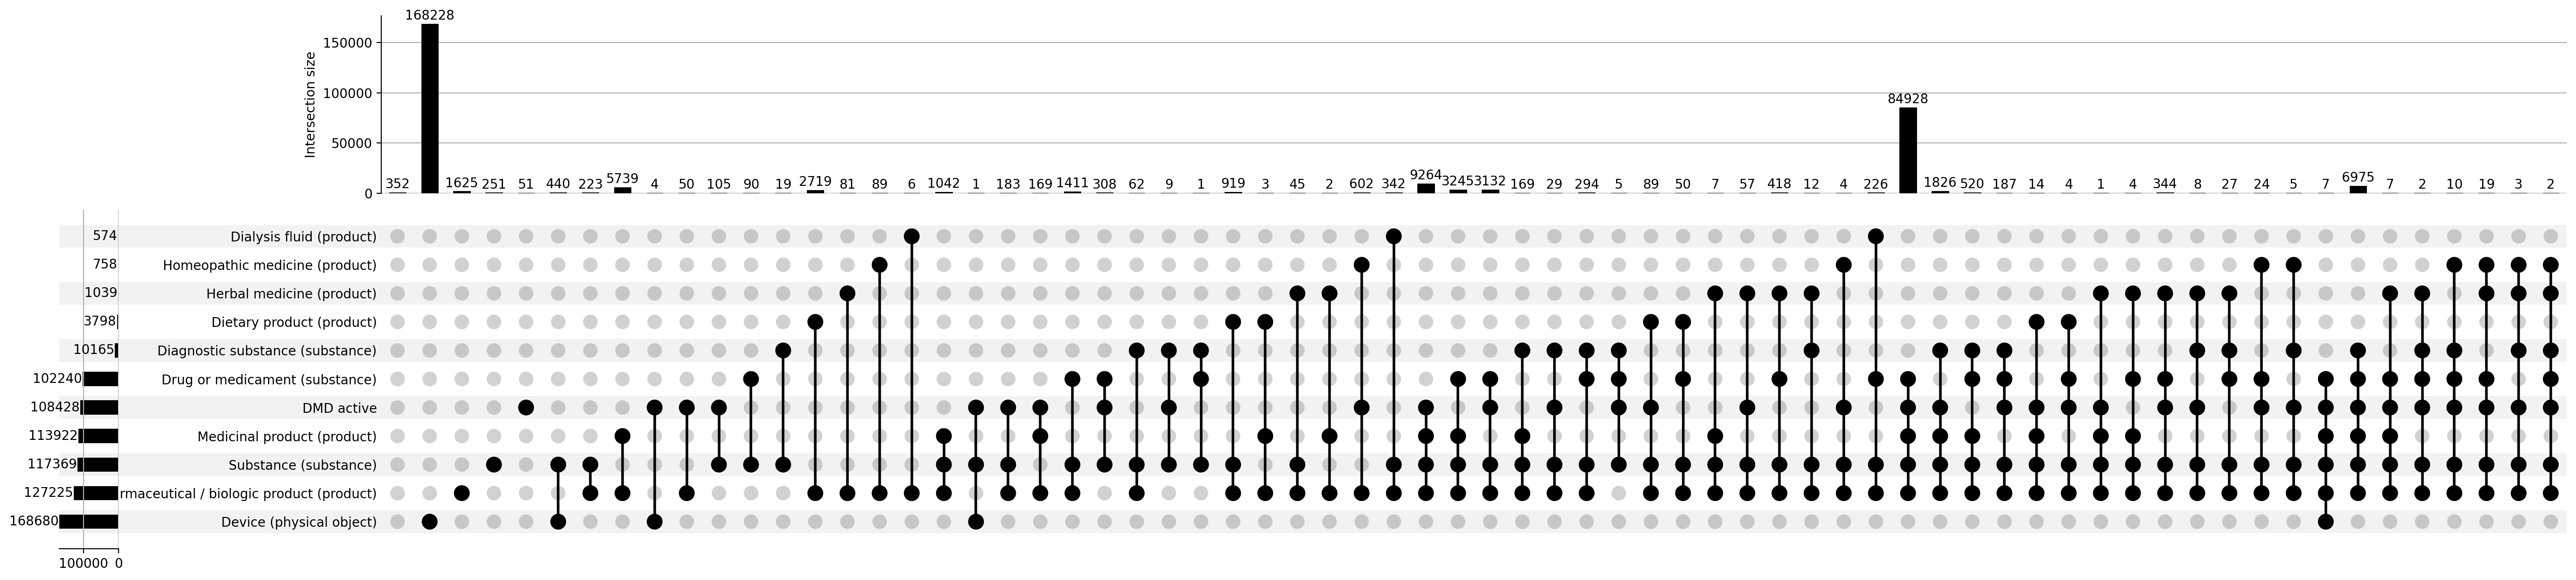

In [24]:
upset_plot(c)

Looking at the relationships:

1. The vast majority split neatly into two disjoint sets, the Device/UK device set and a Set that comprises of all the remaining concepts that could cenceivably relate to drugs.
2. There are a lot of small contributions of different intersections many of which cross the drug/device interface.
3. All of the Drug or medicament, should intersect with the substance definitions, and they do. Although, there are 270 substances that do not overlap with anything.
4. There are 352 prescriptions that are not overlaping with anything.

Clearly there are too many categories and a lot of overlaps. Whilst I intended a multi-label classifier, I am not sure if it is worth keeping this level on complexity. So, I will merge some categories and simplify.

As a first start, I will eleminate the root class from the intersection with the sub-classes. This will remove a lot of intersections with no loss in information. We will still have the root classes represented.

In [25]:
# The root/subslasses to me merged/removed
merge_terms = [
    ('Substance (substance)', 'Drug or medicament (substance)'),
    ('Substance (substance)', 'Diagnostic substance (substance)'),
    ('Pharmaceutical / biologic product (product)', 'Medicinal product (product)'),
    ('Pharmaceutical / biologic product (product)', 'Drug-device combination product (product)'),
    ('Pharmaceutical / biologic product (product)', 'Dialysis fluid (product)'),
    ('Pharmaceutical / biologic product (product)', 'Dietary product (product)'),
    ('Pharmaceutical / biologic product (product)', 'Herbal medicine (product)'),
    ('Pharmaceutical / biologic product (product)', 'Homeopathic medicine (product)'),
]

In [26]:
for root, concept in merge_terms:
    c.loc[c[concept], root] = False

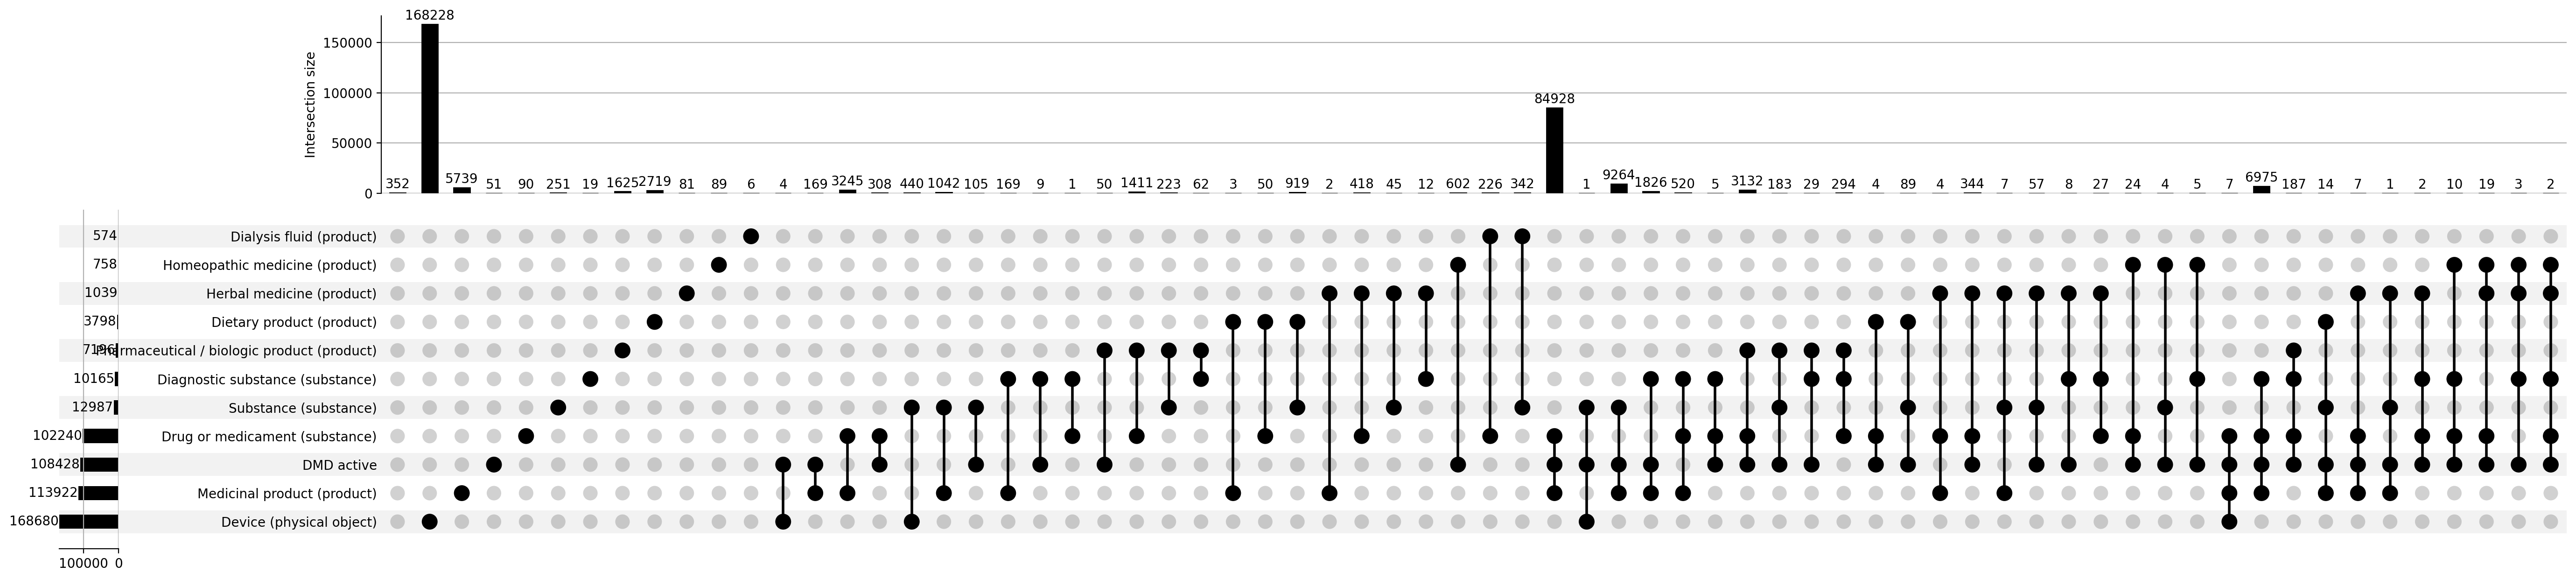

In [27]:
upset_plot(c)

There are still too many categories, so not for any "drug" categories, I will remove them if they overlap with the DMD active flag, as I think they mean the same thing. I do not think this will reduce the information available and we will still have representatives of these classes with no active flag, although, what these actually are is unknown.

In [28]:
dmd_collapse = [
    'Substance (substance)',
    'Pharmaceutical / biologic product (product)',
    'Drug or medicament (substance)',
    'Medicinal product (product)',
]

In [29]:
for i in dmd_collapse:
    c.loc[c['DMD active'], i] = False

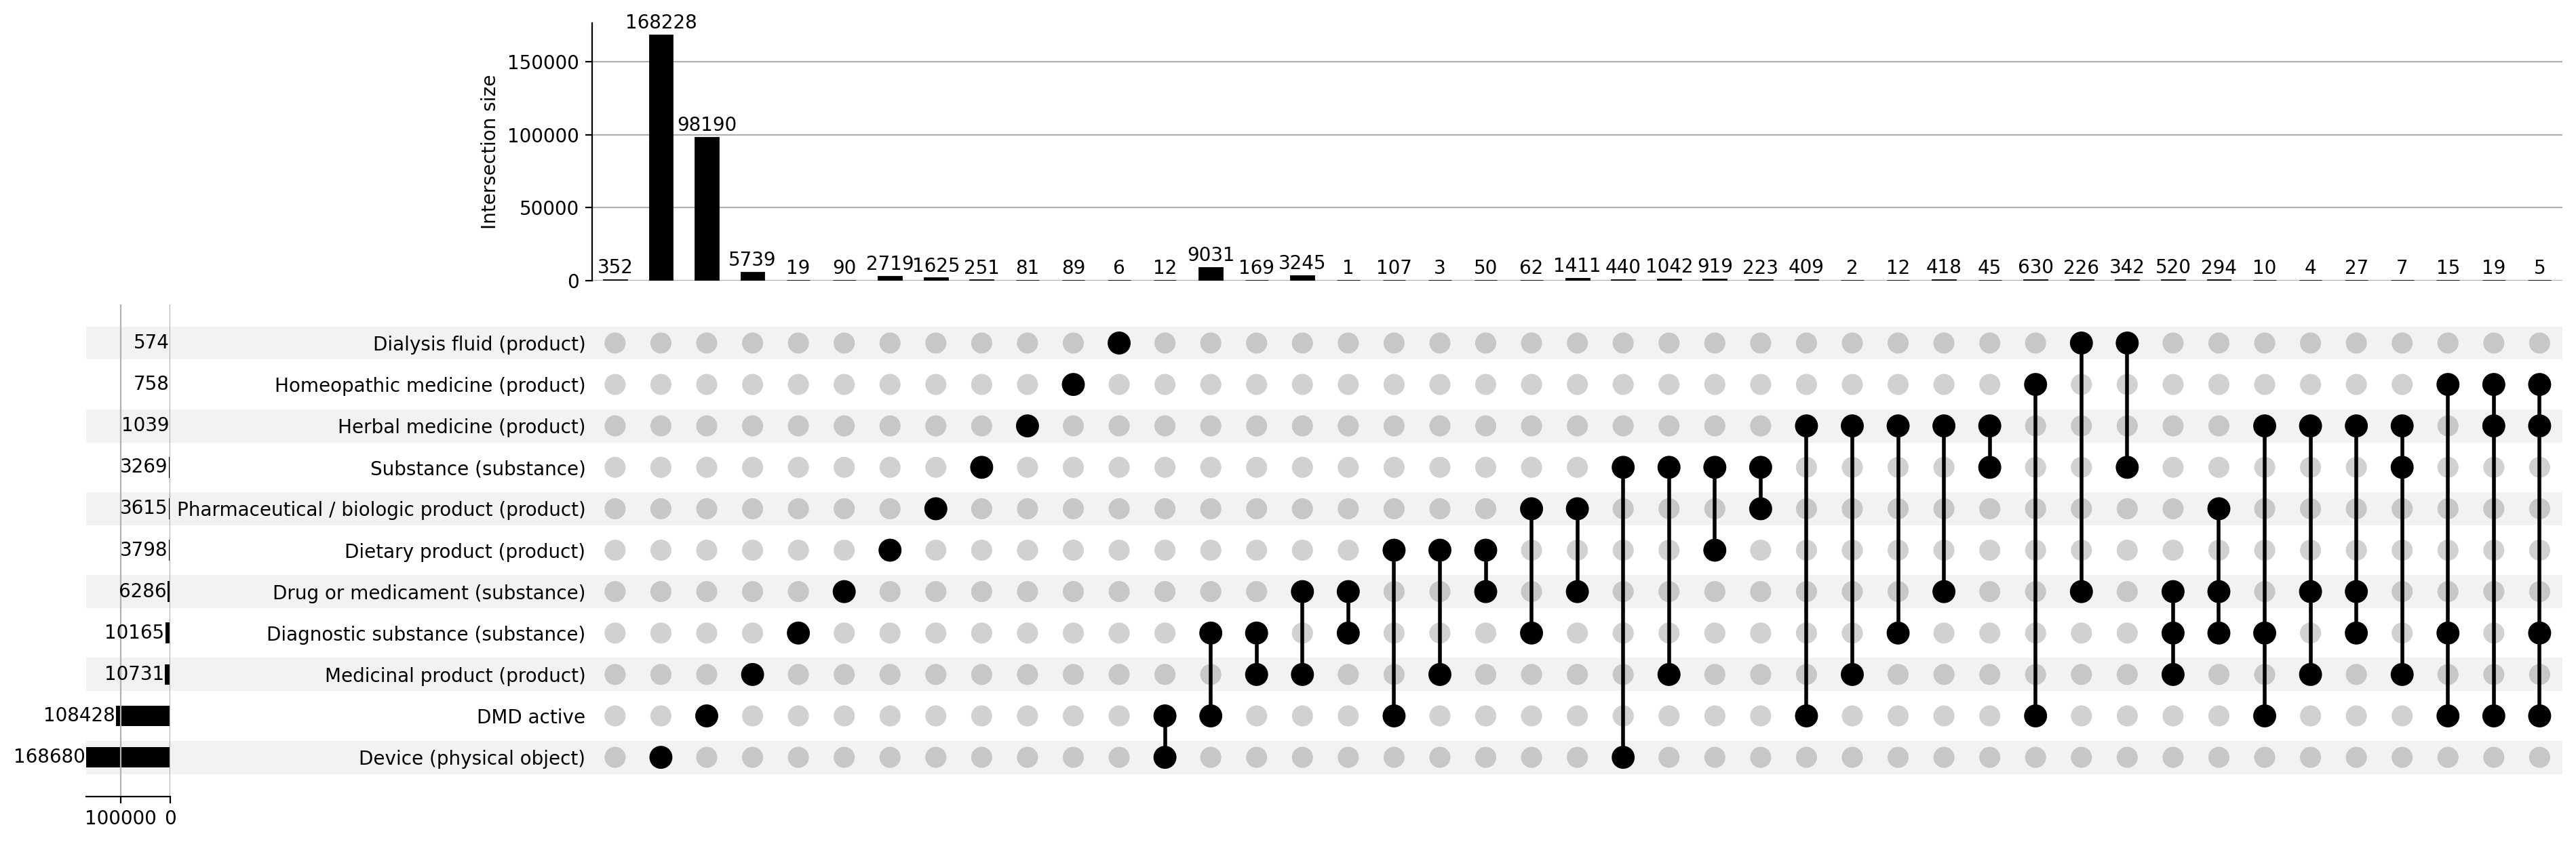

In [30]:
upset_plot(c)

Now we can clean up the herbal/homeopathic columns. For any columns that intersect with these values with the exception of the `DMD active` column. We will remove the intersection with that column. This will also remove Herbal medicine intersections with Homeopathic medicine but that is fine.

In [31]:
for i in ['Homeopathic medicine (product)', 'Herbal medicine (product)']:
    for j in c.columns[~c.columns.isin(['DMD active', i])]:
        c.loc[(c[i]) & (c[j]), j] = False

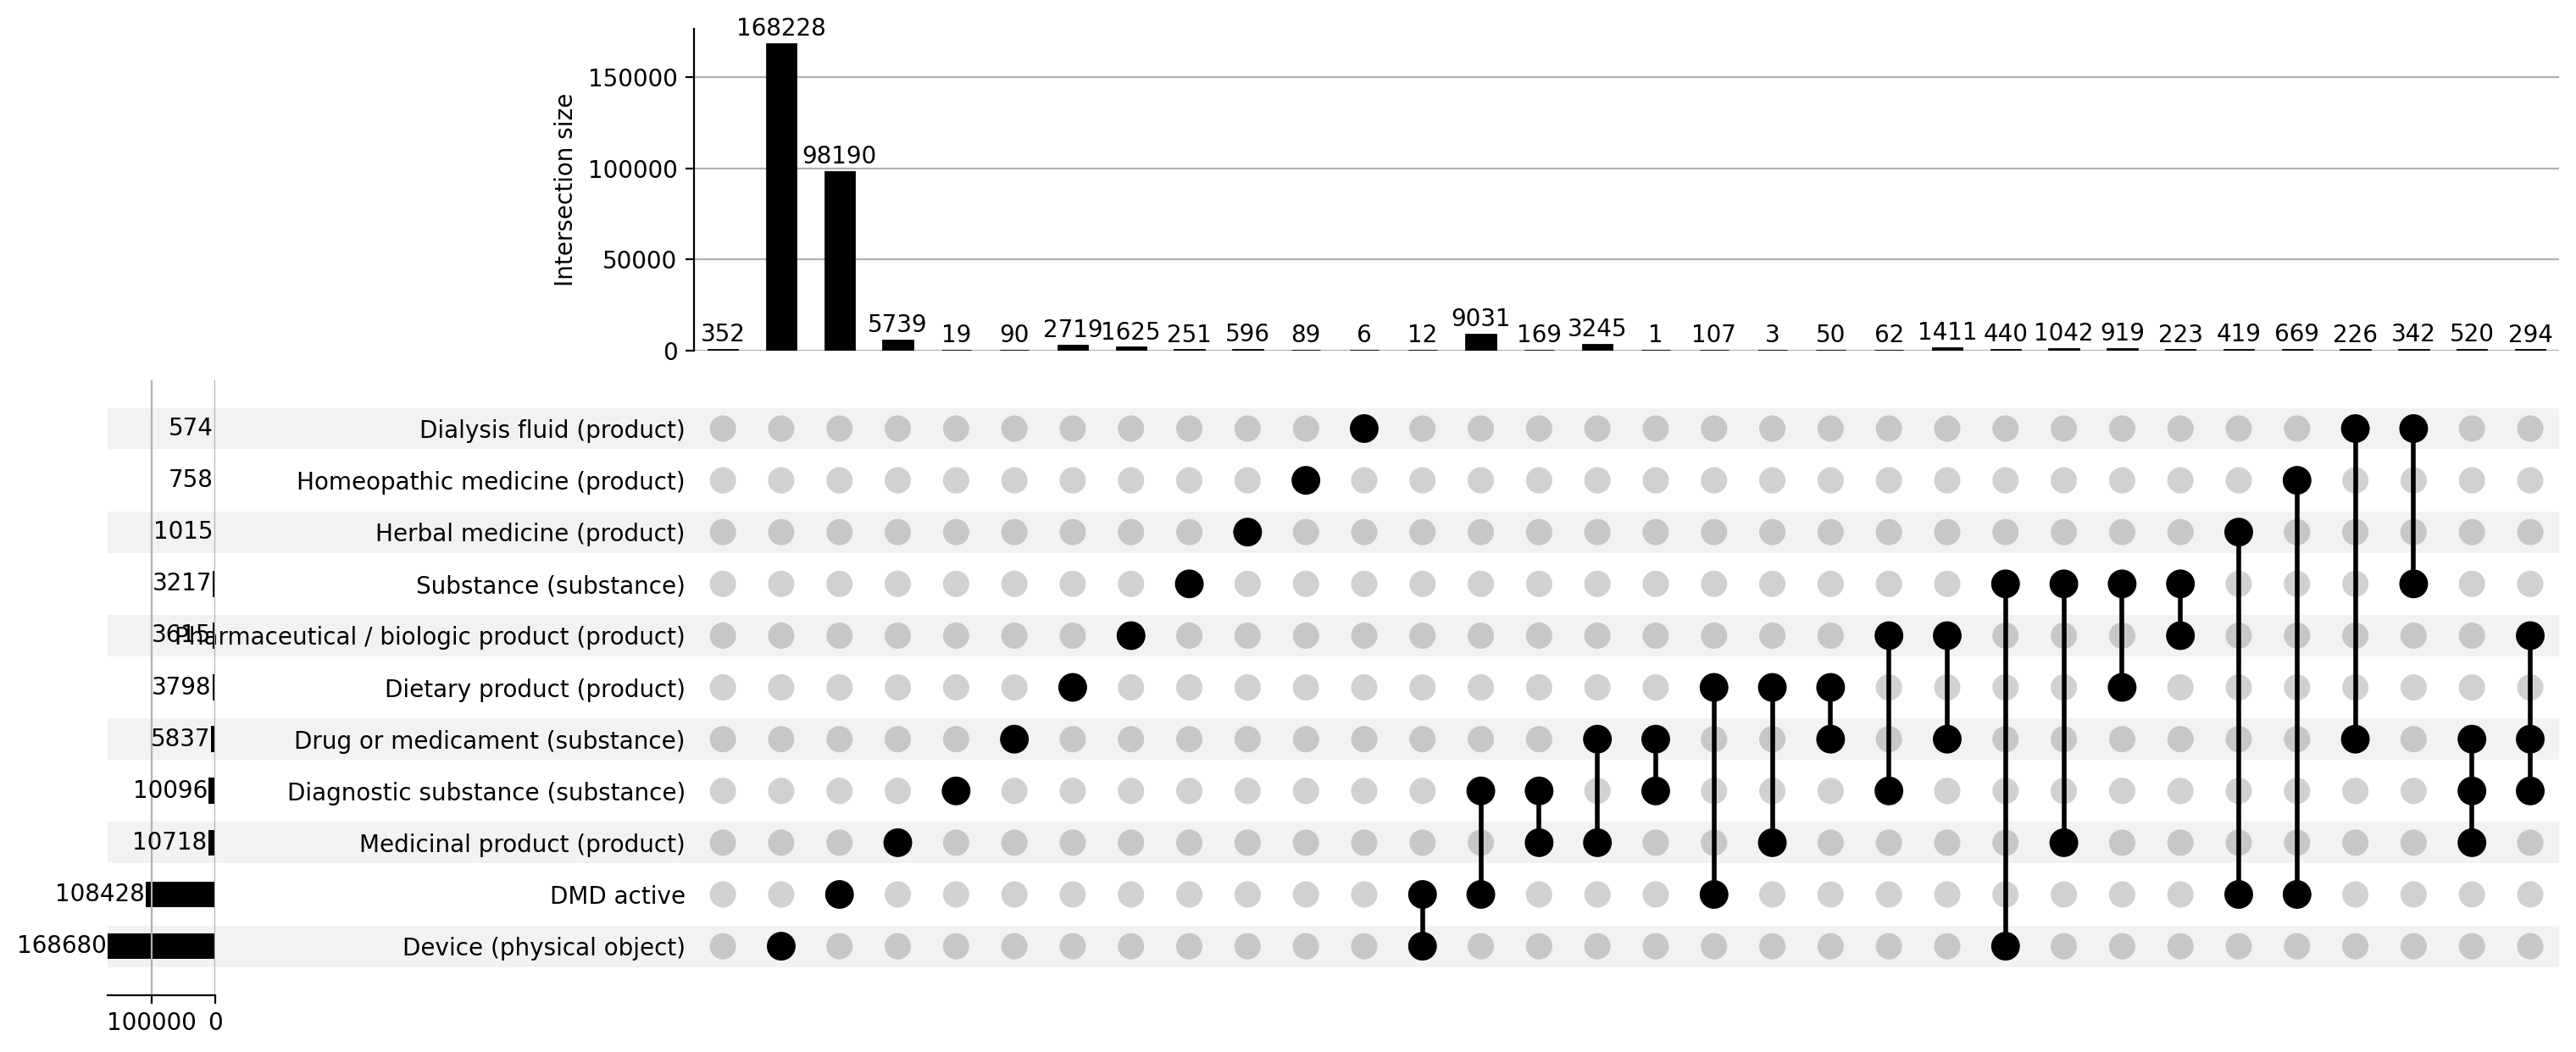

In [32]:
upset_plot(c)

The Substance class is quite high level and intersects with a few other columns. I will remove the substance intersections from the other columns.

In [33]:
for i in c.columns[~(c.columns == 'Substance (substance)')]:
    c.loc[(c['Substance (substance)']) & (c[i]), 'Substance (substance)'] = False

Similarly, any intersections with dialysis fluid will be remoed in favour of the dialysis fluid.

In [34]:
# Collapse into dialysis fluid
for i in c.columns[~(c.columns == 'Dialysis fluid (product)')]:
    c.loc[(c['Dialysis fluid (product)']) & (c[i]), i] = False

Any columns that intersect with diagnostic substances, apart from the DMD active flag, will have their intersection removed.

In [35]:
for i in c.columns[~c.columns.isin(['DMD active', 'Diagnostic substance (substance)'])]:
    c.loc[(c['Diagnostic substance (substance)']) & (c[i]), i] = False

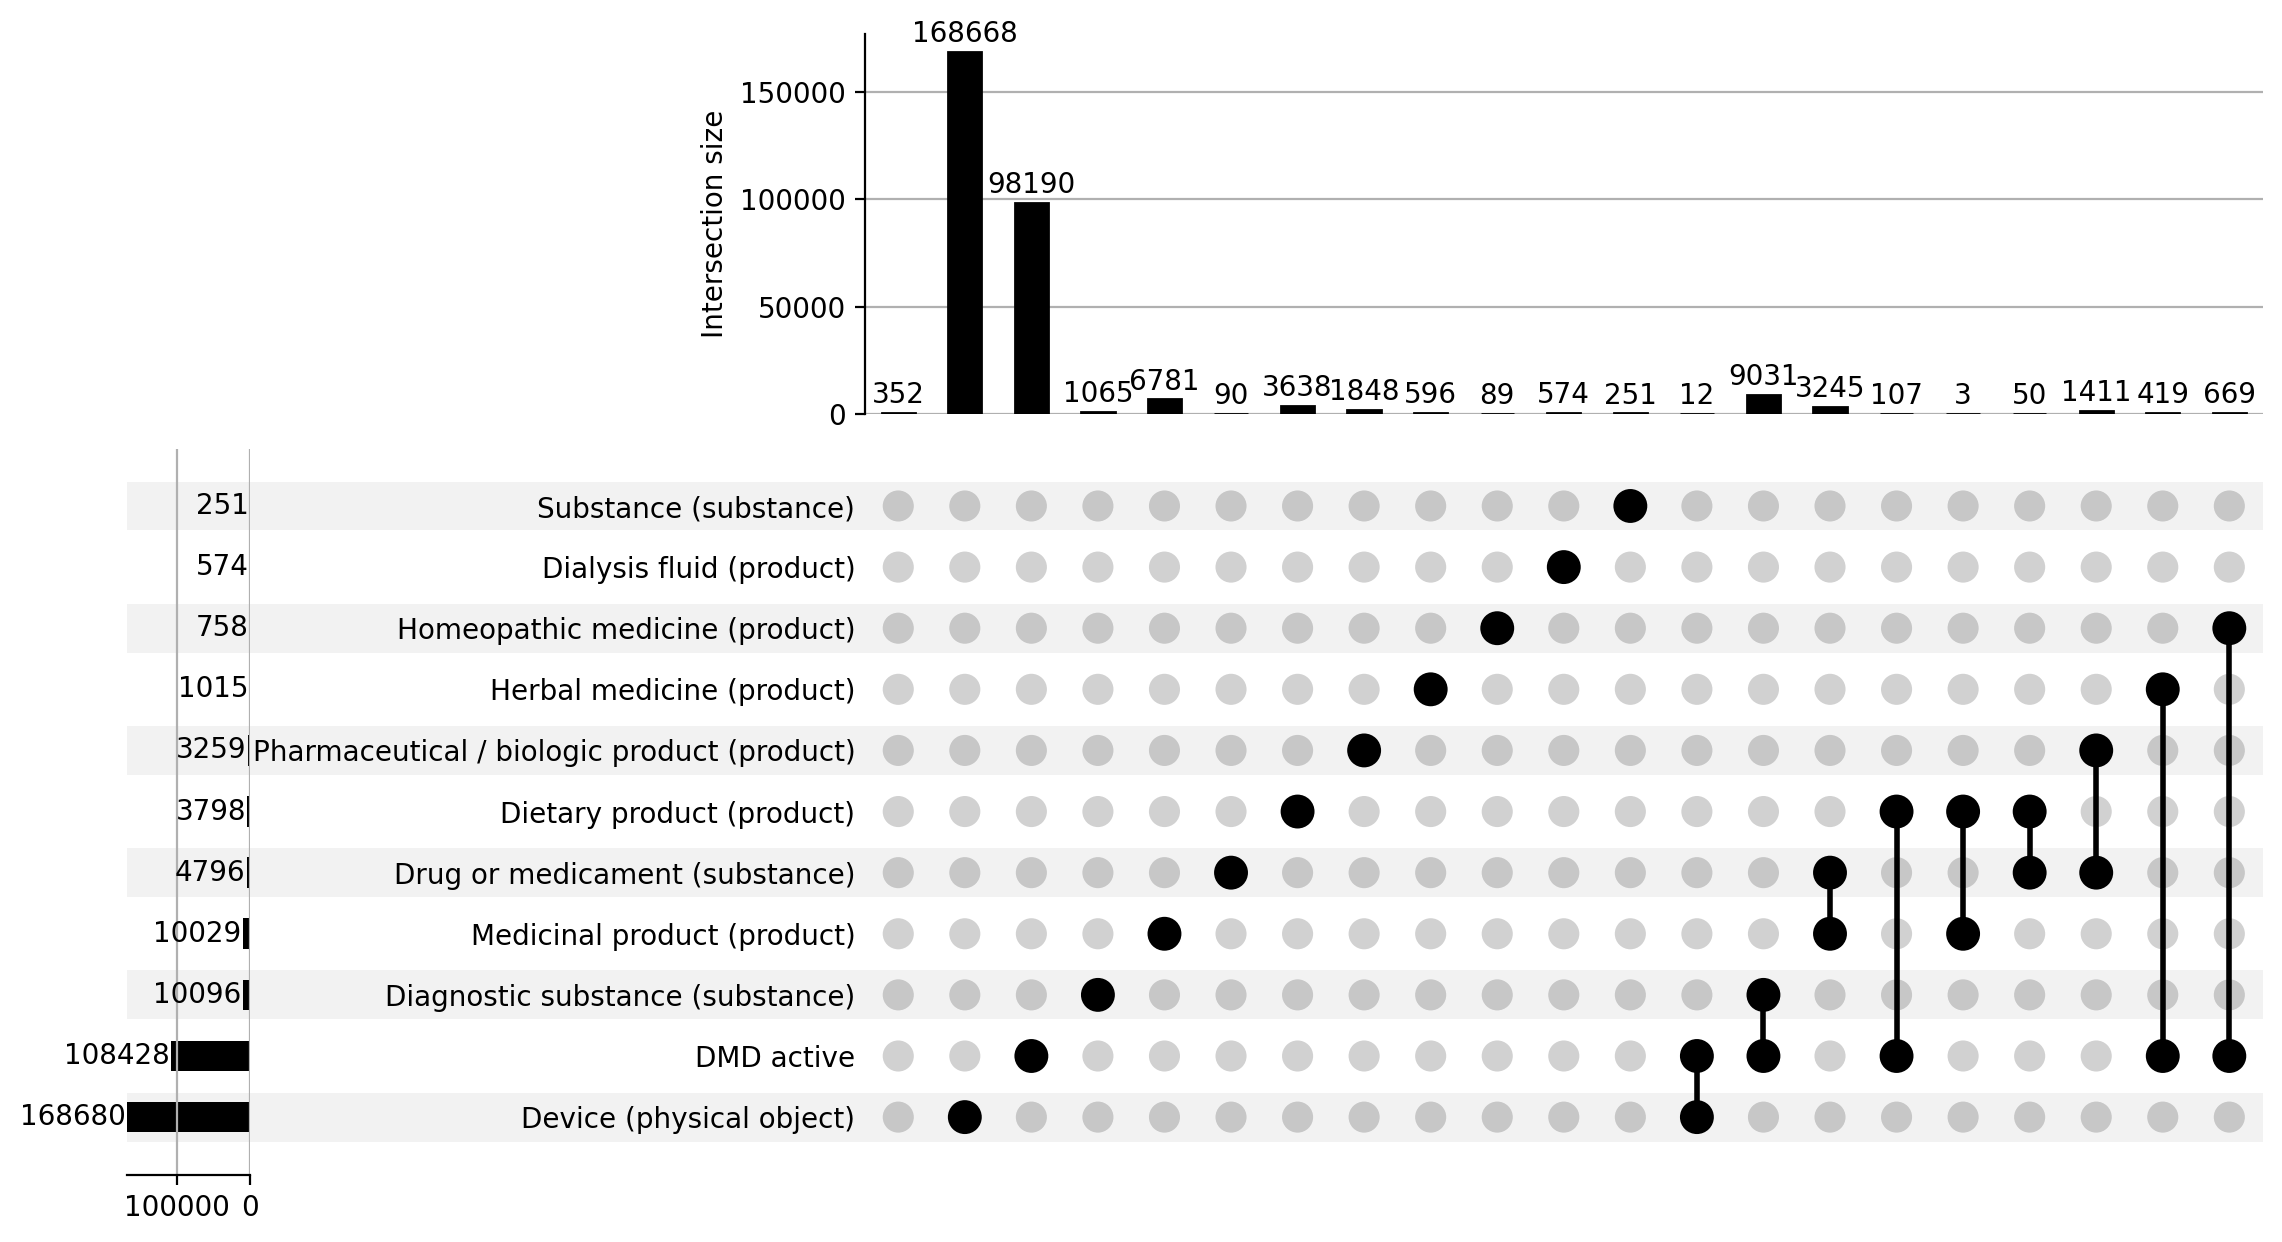

In [36]:
upset_plot(c)

Now merge any intersections between `Pharmaceutical / biologic product (product)` and `Drug or medicament (substance)` in faviour of `Drug or medicament (substance)`

In [37]:
pharma_selector = c['Pharmaceutical / biologic product (product)'] == True
c.loc[pharma_selector, 'Pharmaceutical / biologic product (product)'] = False
c.loc[pharma_selector, 'Drug or medicament (substance)'] = True

Remove all intersections between `Drug or medicament (substance)` and any other class.

In [38]:
for i in c.columns[~(c.columns == 'Dietary product (product)')]:
    c.loc[(c['Dietary product (product)']) & (c[i]), i] = False

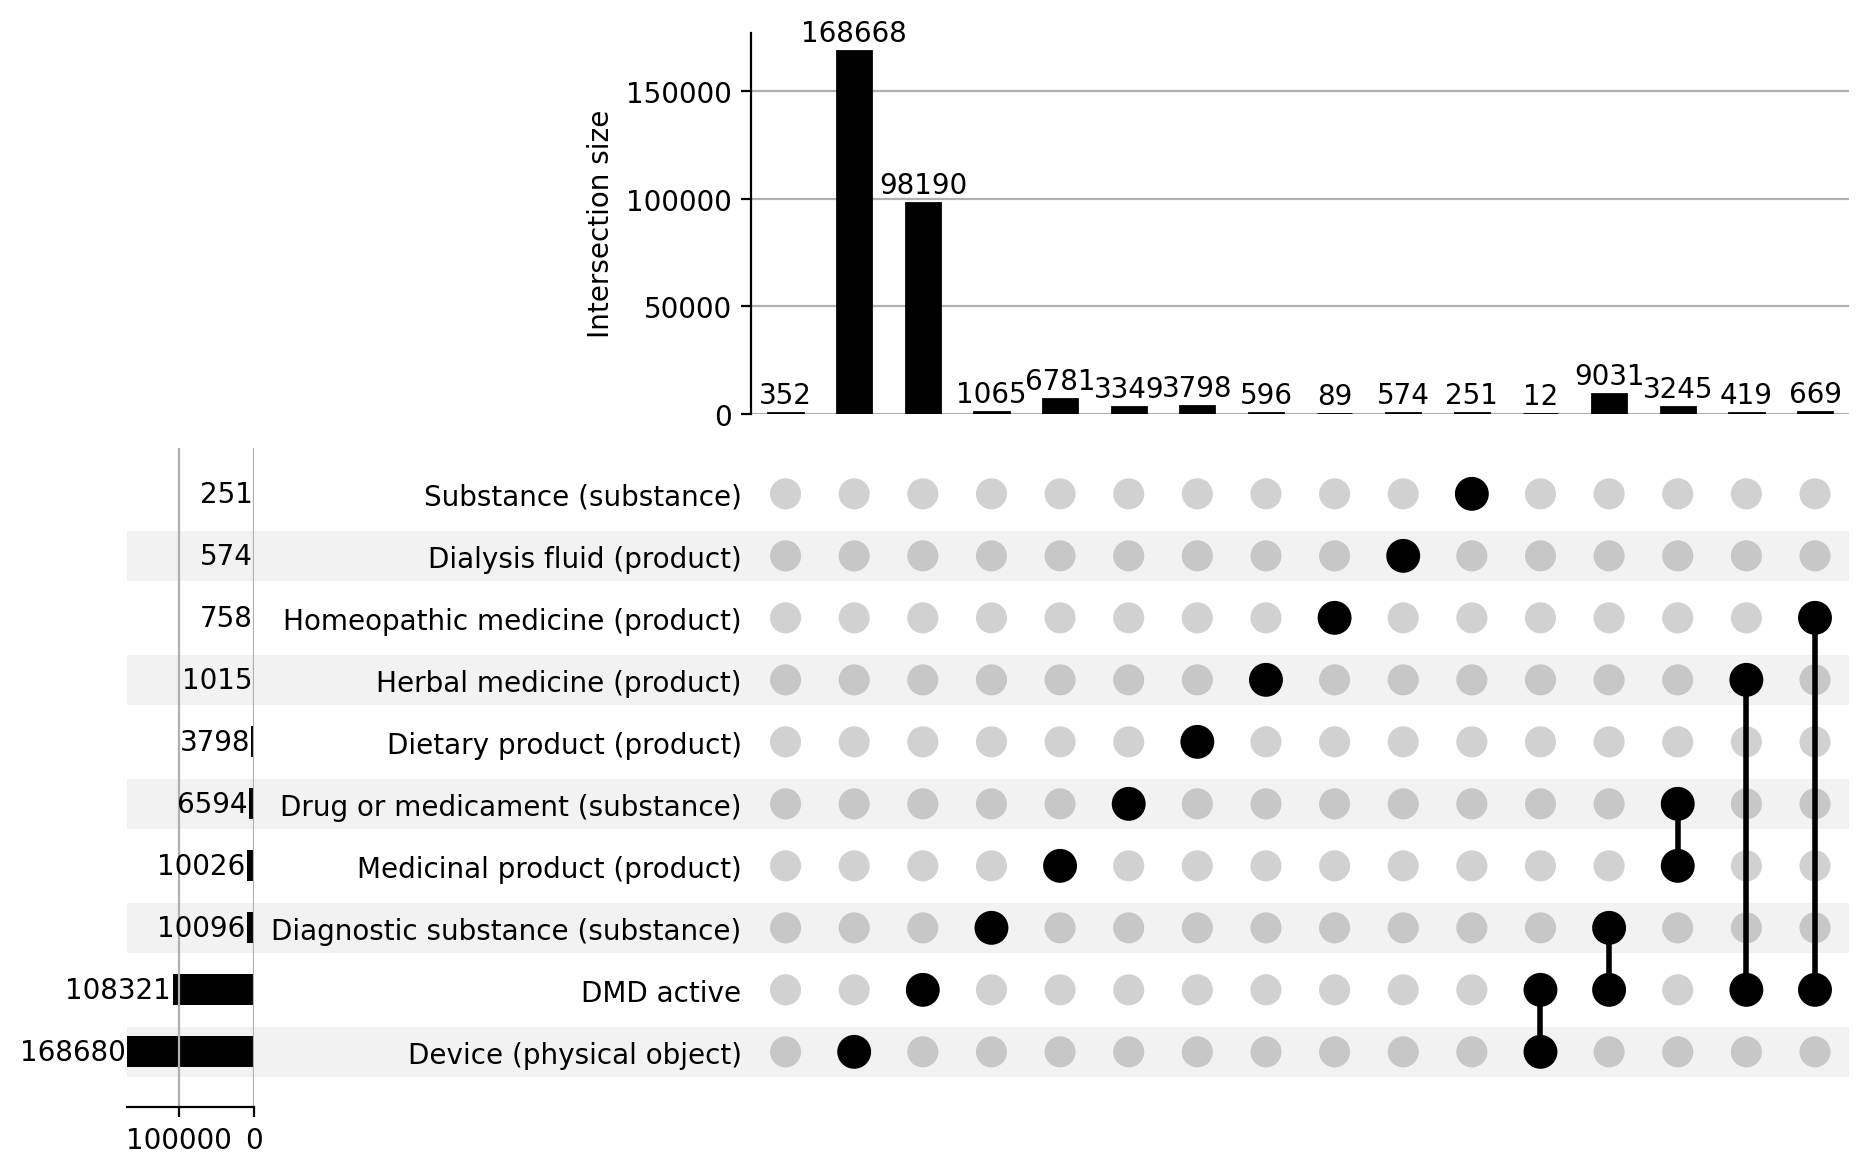

In [39]:
upset_plot(c)

### What are the unclassified prescriptions
Before I wrap up this exploration, I want to take a quick look at the prescriptions that do not fall into these categories and also those that are `Substance (substance)` only.

To do this I will add a count and select those with 0

In [40]:
pd.options.display.max_rows = None
in_dmd.loc[c.loc[c.sum(axis=1) == 0].index]

pres_str_name
pres_str_id                                                                                                                                                     
9703                                                                                                                  Lancets sterile single use 0.20mm/33 gauge
16879                                                                                                                              Dilatation catheter male 16Ch
16882                                                                                                                              Dilatation catheter male 18Ch
17525                                                                     Generic Pollinex Grasses suspension for injection treatment and extension course vials
18771                                                                                                                                     Sunscreen cream SPF 15
18772                                                                                                                                     Sunscreen cream SPF 50
18778                                                                                                                        Generic T/Gel shampoo for oily hair
18784                                                                                                                                  Sunscreen lip balm SPF 30
21078                                                                                                                                    Sunscreen lotion SPF 28
21080                                                                                                                                     Sunscreen cream SPF 20
21087                                                                                                                                     Sunscreen cream SPF 30
21121                                                                                                                                    Sunscreen lotion SPF 60
21133                                                                                                                                    Sunscreen lotion SPF 30
21134                                                                                                                                    Sunscreen lotion SPF 15
21135                                                                                                                                    Sunscreen lotion SPF 20
21136                                                                                                                                    Sunscreen lotion SPF 25
21148                                                                                                                                    Sunscreen lotion SPF 50
21159                                                                                                                                     Sunscreen cream SPF 25
21747                                                                                                           Lancets sterile single use type B 0.66mm/23gauge
21749                                                                                                            Lancets sterile single use type C 0.4mm/28gauge
21790                                                                                                           Lancets sterile single use type A 0.66mm/23gauge
21792                                                                                                            Lancets sterile single use type A 0.8mm/21gauge
21794                                                                                                            Lancets sterile single use type A 0.4mm/28gauge
22110                                                                                                                   Op

So, it looks like a mish-mash of stuff but there are some things that stand out such as sunscreen and a bunch of dressings and lymphoedema garments, that I am not sure why they are not classified elsewhere. The sunscreen I might regex out in future.

At the moment some of these things might be covered by the very large devices class, I could conceivably add bandages, lymphoedema garment classes in future.

In [60]:
# Lmphoedema garment
lymph_df = pd.DataFrame(
    session.query(
        orm.PresStringSnomed.pres_str_id,
        sqlalchemy.literal(True)
    ).filter(
        orm.PresStringSnomed.concept_term.like("%Lymphoedema garment%")
    ).group_by(
        orm.PresStringSnomed.pres_str_id
    ),
    columns=['pres_str_id', 'Lymphoedema garment']
).set_index('pres_str_id')

In [61]:
pd.options.display.max_rows = 20
lymph_df

Lymphoedema garment
pres_str_id                     
60259                       True
60260                       True
60261                       True
60262                       True
60263                       True
...                          ...
296617                      True
296618                      True
296619                      True
296620                      True
296621                      True

[111131 rows x 1 columns]

In [62]:
c = c.merge(lymph_df, left_index=True, right_index=True, how='left')

In [63]:
c[c.isnull()] = False

In [59]:
c = c.drop('concept_term',axis='columns')

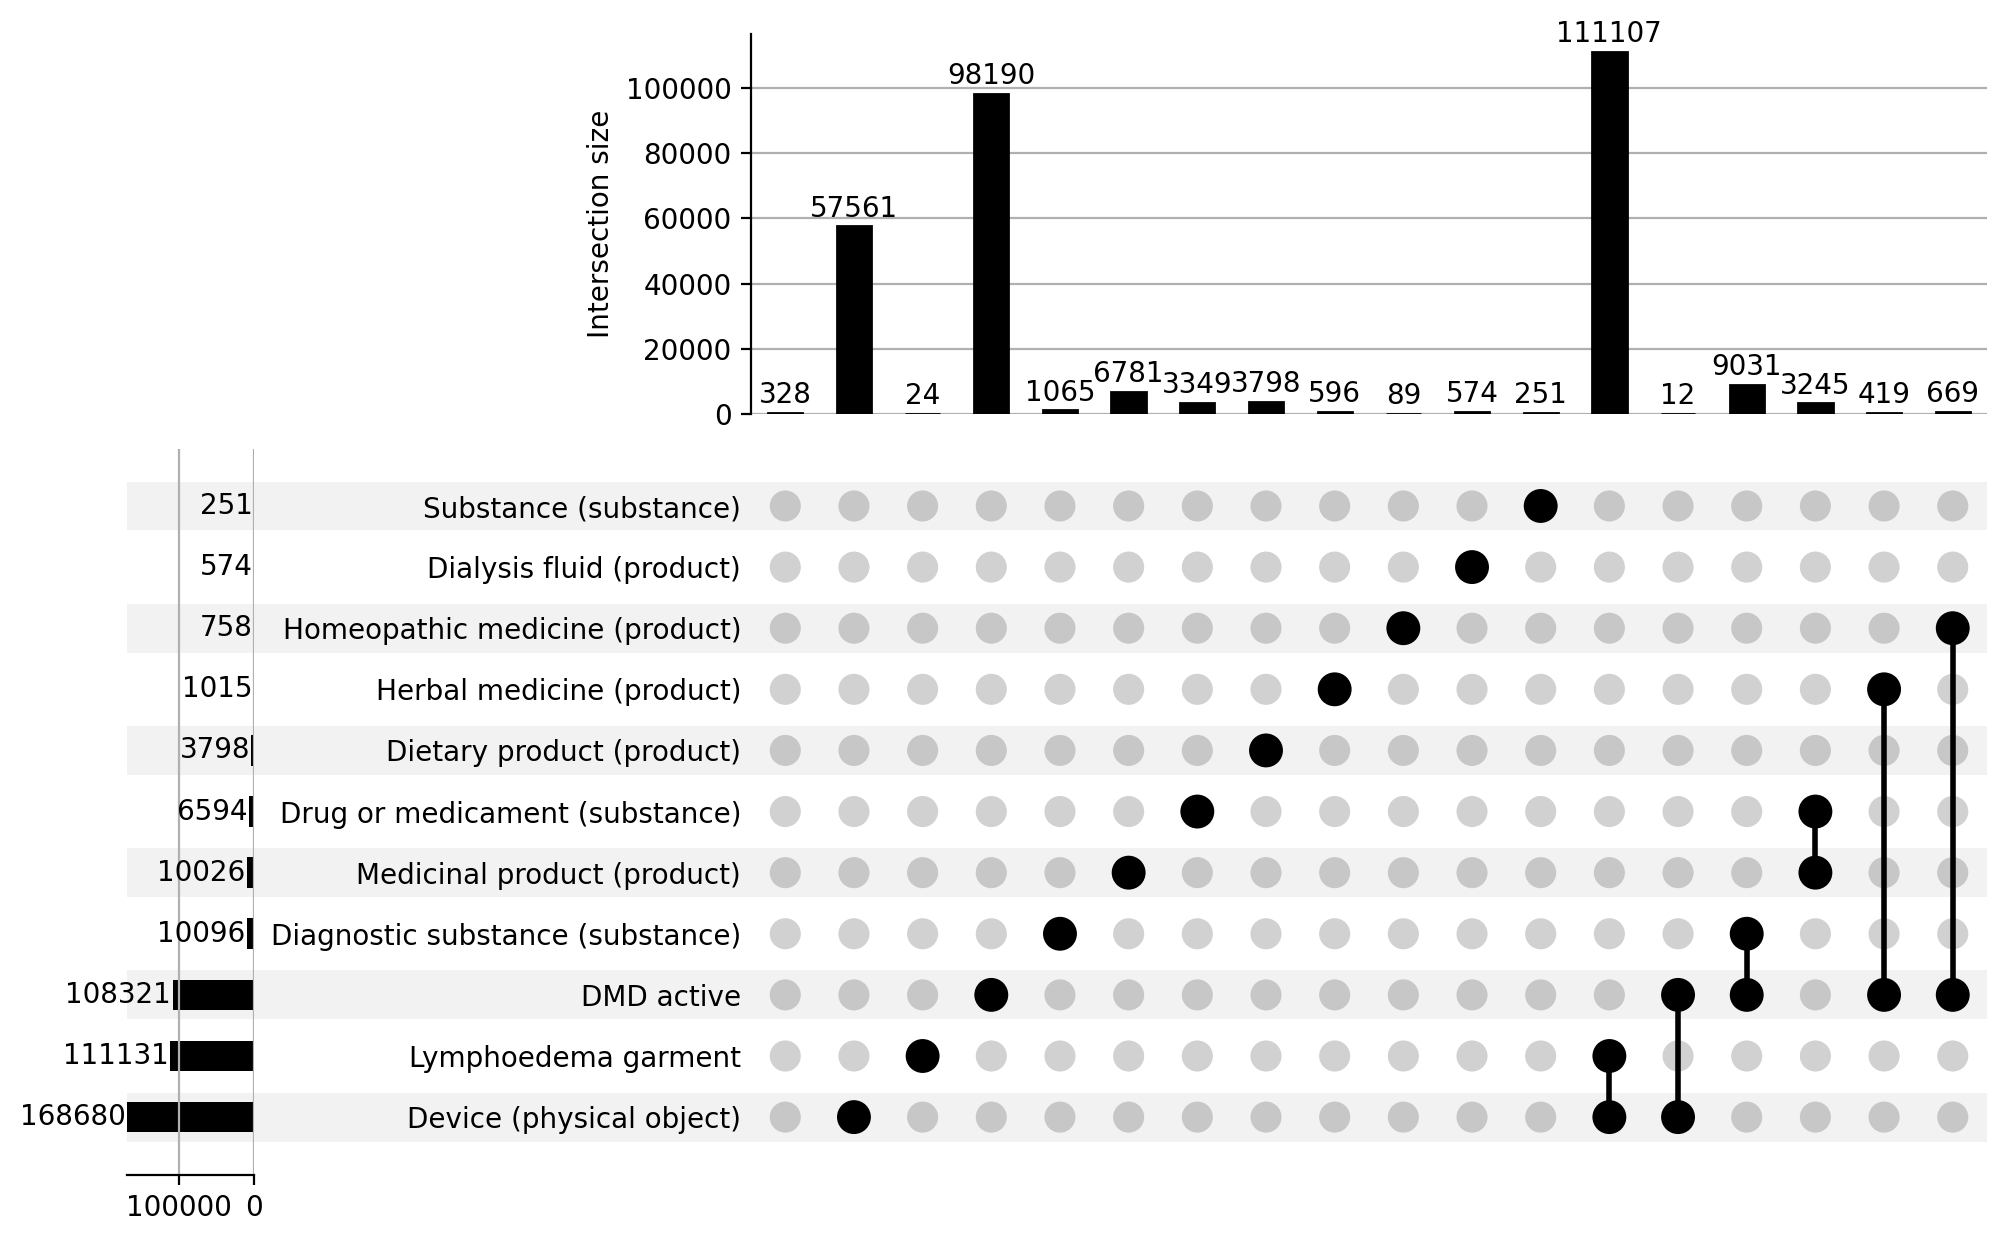

In [64]:
upset_plot(c)

In [68]:
in_dmd.loc[in_dmd.pres_str_name.str.contains(r'[sS]unscreen')]

pres_str_name
pres_str_id                                                        
4390              Reflectant sunscreen beige (Dundee formula) cream
4391             Reflectant sunscreen coffee (Dundee formula) cream
4392         Reflectant sunscreen coral pink (Dundee formula) cream
13172                                               Sunscreen cream
13173                                            Sunscreen lip balm
...                                                             ...
183597                          E45 Sun reflective sunscreen SPF 25
183598                          E45 Sun reflective sunscreen SPF 50
196694                          E45 Sun reflective sunscreen SPF 20
196695                         E45 Sun reflective sunscreen SPF 30+
233314                           Anthelios sunscreen lotion SPF 50+

[29 rows x 1 columns]

In [71]:
pd.options.display.max_rows = 20
in_dmd.loc[in_dmd.pres_str_name.str.contains(r'[Pp]essary')]

pres_str_name
pres_str_id                                                     
1251                Ring pessary size 0, 45mm diameter, silicone
6310              Ring pessary size 10, 108mm diameter, silicone
6311              Ring pessary size 11, 114mm diameter, silicone
6312              Ring pessary size 12, 121mm diameter, silicone
6313              Ring pessary size 13, 127mm diameter, silicone
...                                                          ...
297069        Milex ring pessary size 5, 76mm diameter, silicone
297070        Milex ring pessary size 6, 83mm diameter, silicone
297071        Milex ring pessary size 7, 89mm diameter, silicone
297072        Milex ring pessary size 8, 95mm diameter, silicone
297073       Milex ring pessary size 9, 102mm diameter, silicone

[715 rows x 1 columns]

In [72]:
pd.options.display.max_rows = 20
in_dmd.loc[in_dmd.pres_str_name.str.contains(r'[Cc]atheter')]

pres_str_name
pres_str_id                                                                                                                                                                                              
1038                                                                                                                                                                     Nelaton catheter paediatric 14Ch
2774                                                                                                                               Sodium chloride 0.9% catheter maintenance solution pre-filled syringes
3042                                                                                                                                                                          Nelaton catheter unisex 8Ch
3043                                                                                                                                                                         Nelaton catheter unisex 10Ch
3044                                                                                                                                                                         Nelaton catheter unisex 12Ch
...                                                                                                                                                                                                   ...
298575              FlexiCath silicone catheter with pre-filled syringe for balloon inflation and supplementary syringe for balloon deflation female 14Ch 00-121405C 10ml balloon (Flexicare Medical Ltd)
298576              FlexiCath silicone catheter with pre-filled syringe for balloon inflation and supplementary syringe for balloon deflation female 16Ch 00-121605C 10ml balloon (Flexicare Medical Ltd)
298577        FlexiCath silicone catheter with pre-filled syringe for balloon inflation and supplementary syringe for balloon deflation paediatric 6Ch 00-110603C 3ml-5ml balloon (Flexicare Medical Ltd)
298578        FlexiCath silicone catheter with pre-filled syringe for balloon inflation and supplementary syringe for balloon deflation paediatric 8Ch 00-110803C 3ml-5ml balloon (Flexicare Medical Ltd)
298579       FlexiCath silicone catheter with pre-filled syringe for balloon inflation and supplementary syringe for balloon deflation paediatric 10Ch 00-111003C 3ml-5ml balloon (Flexicare Medical Ltd)

[6702 rows x 1 columns]

In [74]:
c['Sunscreen'] = False
c.loc[in_dmd.loc[in_dmd.pres_str_name.str.contains(r'[sS]unscreen')].index,'Sunscreen'] = True

In [79]:
c['Catheter'] = False
c.loc[c.index.intersection(in_dmd.loc[in_dmd.pres_str_name.str.contains(r'[Cc]atheter')].index),'Catheter'] = True

In [80]:
c['Pessary'] = False
c.loc[c.index.intersection(in_dmd.loc[in_dmd.pres_str_name.str.contains(r'[Pp]essary')].index),'Pessary'] = True

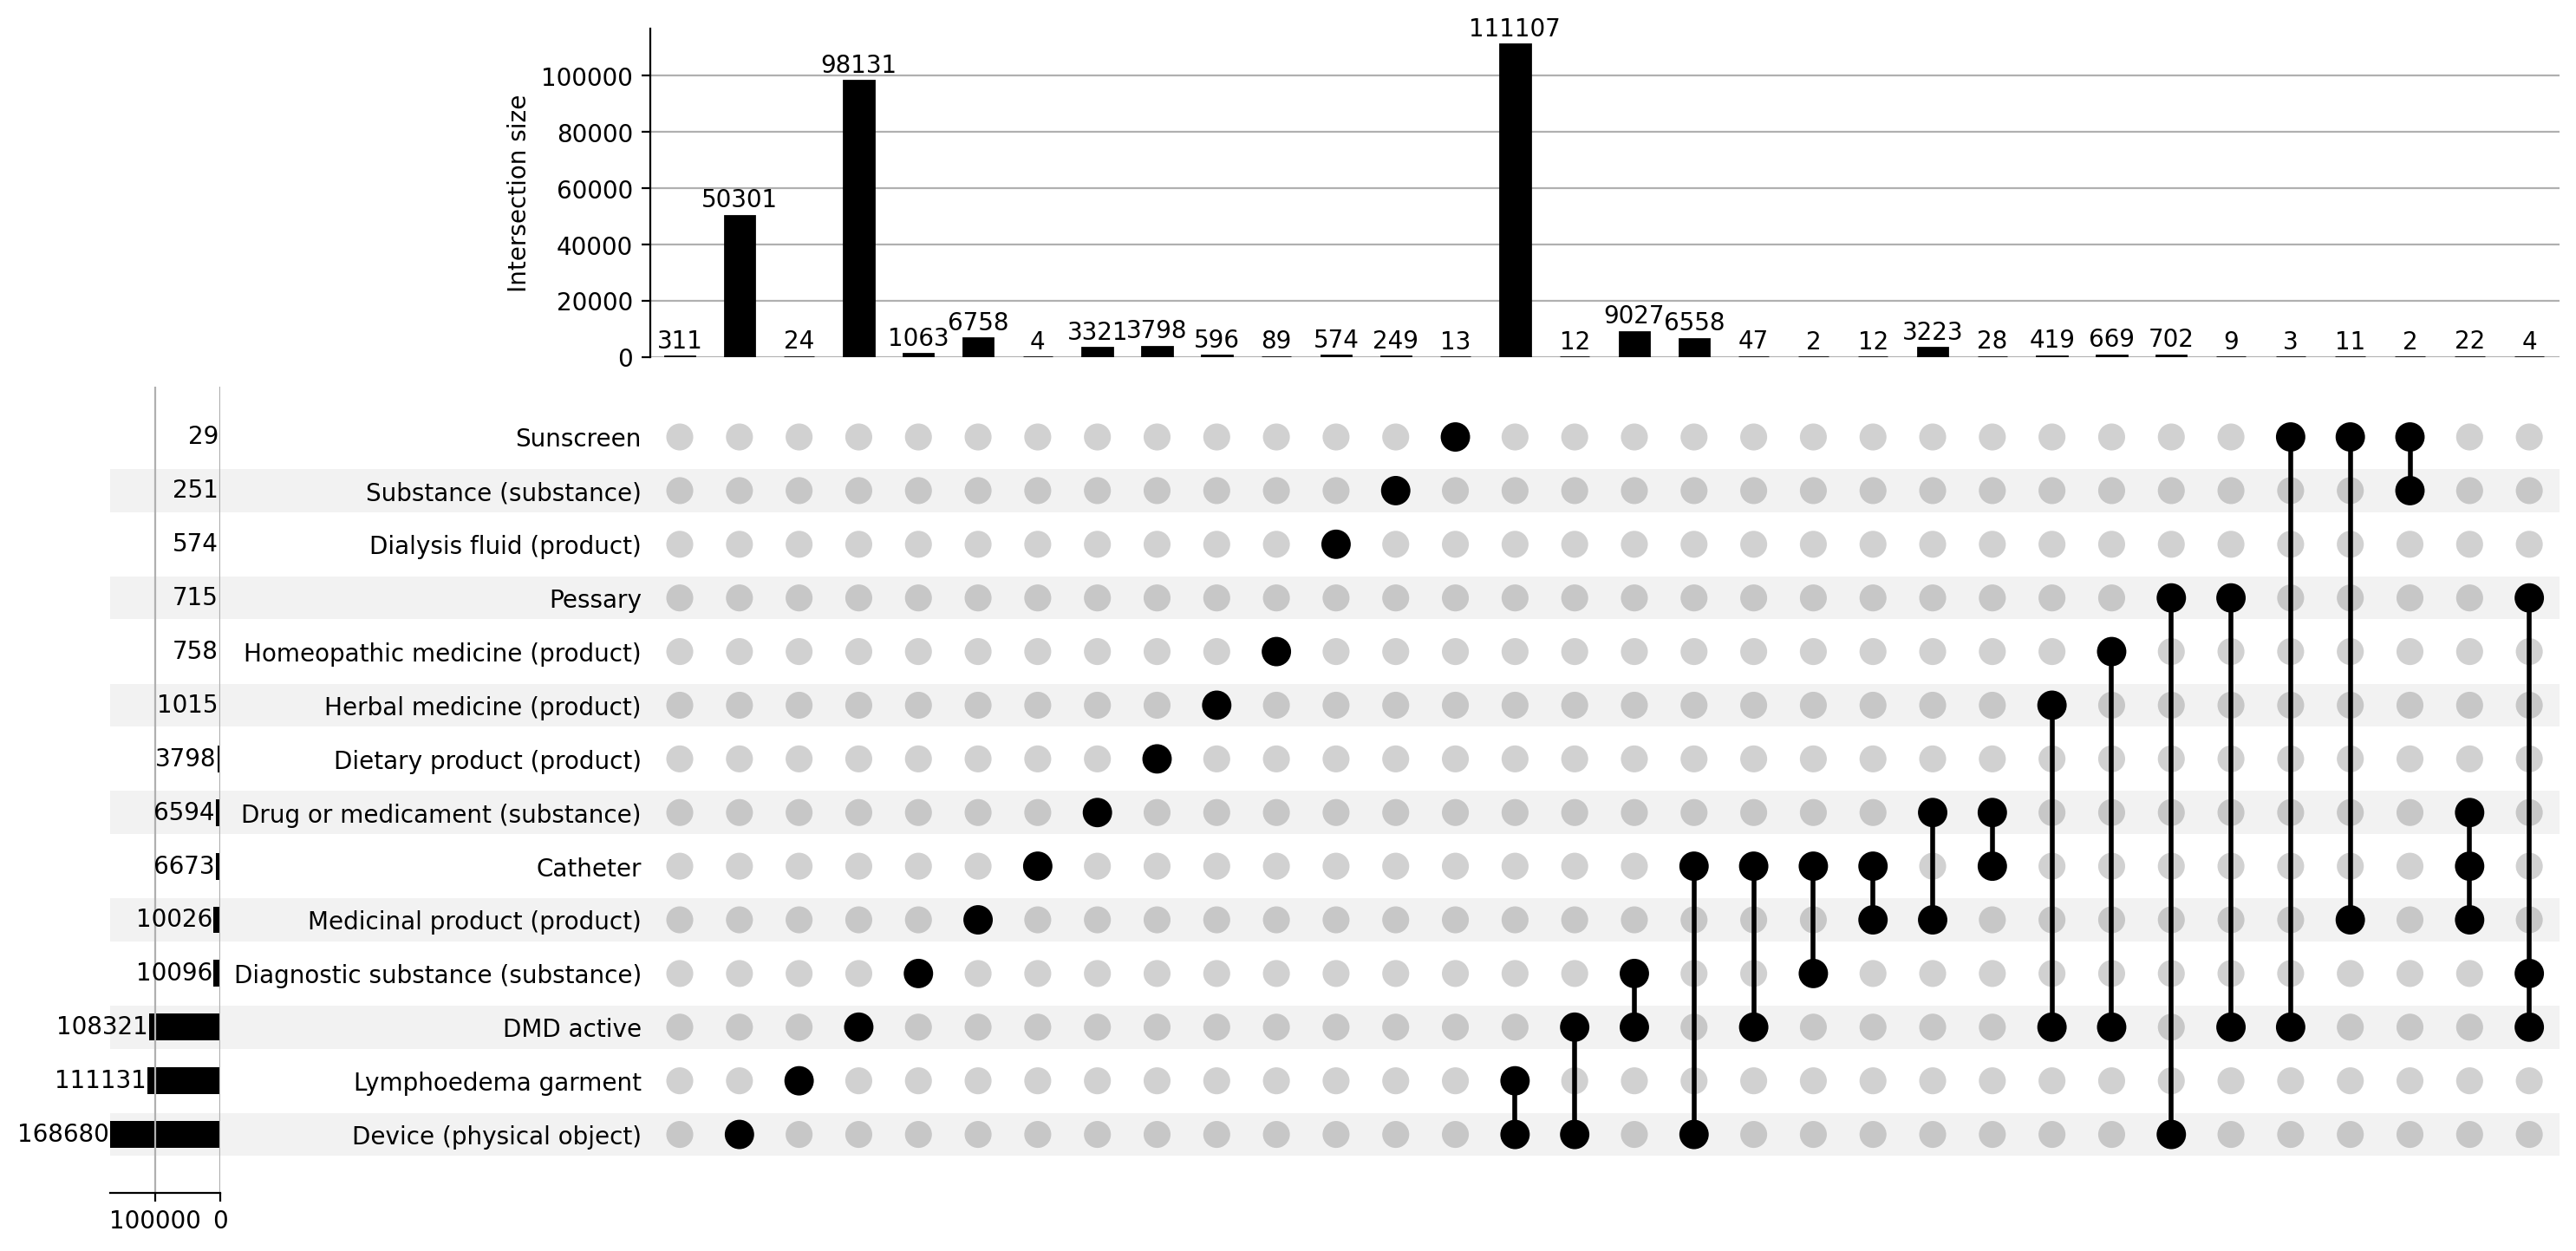

In [81]:
upset_plot(c)